# Objective

Predict the direction of a crypto asset's price movement for the next minute based on historical minute-by-minute price data.

# Task

- Build a model to predict whether the price will move up (1) or stay the same/move down (0) in the next minute
- Use historical minute-by-minute price information of one crypto asset

# Evaluation Metric

- Macro-Averaged F1 Score
F1 = 2 * ((Precision * Recall) / (Precision + Recall))

- Macro-Averaged F1 = (1/c) * SUM (from c=1 to c) of F1_c

# Technical Requirements

- Innovative feature engineering
- Application of cutting-edge machine learning techniques
- Robust model capable of predicting short-term price movements

## Table Schema

- **timestamp:** A timestamp for the minute covered by the row.

- **open:** The price in USDT at the beginning of the minute.

- **high:** The highest price in USDT during the minute

- **low:** The lowest price in USDT during the minute.

- **close:** The price in USDT at the end of the minute.

- **volume:** The number of crypto asset units traded during the minute.

- **quote_asset_volume:** The total value of the traded shares in USDT during the minute.

- **number_of_trades:** The number of trades that took place during the minute.

- **taker_buy_base_volume:** The total amount of the crypto asset that was bought by takers during the minute.

- **taker_buy_quote_volume:** The total value in USDT that was spent by takers to buy the crypto asset during the minute.

- **target:** The direction of price movement from the current to the next minute. 1 stands for a positive price change and 0 for no or a negative price change.


# **The following is my solution using Google Colab :**

Upload files to Google Colab.

In [106]:
import pandas as pd
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Specify the path to your folder
notebook_path = '/content/drive/My Drive/ColabNotebooks/Crypto(Dreamers)'

# Initialize a dictionary to store DataFrames
dataframes = {}

# Loop through all files in the folder
for filename in os.listdir(notebook_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(notebook_path, filename)
        df_name = filename.split('.')[0]  # Use filename (without extension) as DataFrame name
        dataframes[df_name] = pd.read_csv(file_path)
        print(f"Loaded {filename} into DataFrame '{df_name}'")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded sample_submission.csv into DataFrame 'sample_submission'
Loaded test.csv into DataFrame 'test'
Loaded train.csv into DataFrame 'train'


In [107]:
df = dataframes['train']
df

,timestamp,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_volume,taker_buy_quote_volume,target
0,1525471260,0.90120,0.90130,0.90120,0.90130,134.98,121.646459,4.0,125.08,112.723589,1.0
1,1525471320,0.90185,0.90195,0.90185,0.90195,1070.54,965.505313,12.0,879.94,793.612703,0.0
2,1525471380,0.90140,0.90140,0.90139,0.90139,2293.06,2066.963991,5.0,0.00,0.000000,0.0
3,1525471440,0.90139,0.90140,0.90138,0.90139,6850.59,6175.000909,19.0,1786.30,1610.149485,0.0
4,1525471500,0.90139,0.90139,0.90130,0.90130,832.30,750.222624,3.0,784.82,707.428900,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2122433,1652817240,0.43060,0.43060,0.42990,0.43040,136274.00,58630.162800,144.0,54216.00,23325.927700,1.0
2122434,1652817300,0.43030,0.43070,0.43030,0.43050,104478.00,44967.837600,99.0,52232.00,22484.030400,1.0
2122435,1652817360,0.43050,0.43120,0.43050,0.43090,212396.00,91526.987200,177.0,108324.00,46673.061600,0.0
2122436,1652817420,0.43110,0.43110,0.43040,0.43060,131047.00,56443.003800,107.0,32713.00,14097.148900,0.0


In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2122438 entries, 0 to 2122437
Data columns (total 11 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   timestamp               int64  
 1   open                    float64
 2   high                    float64
 3   low                     float64
 4   close                   float64
 5   volume                  float64
 6   quote_asset_volume      float64
 7   number_of_trades        float64
 8   taker_buy_base_volume   float64
 9   taker_buy_quote_volume  float64
 10  target                  float64
dtypes: float64(10), int64(1)
memory usage: 178.1 MB


**Feature Engineering**

In [109]:
class FeatureEngineering:
    def __init__(self, df):
        self.df = df.copy()

    def engineer_features(self):
        # Ensure number_of_trades is an integer
        self.df['number_of_trades'] = self.df['number_of_trades'].astype('int64')



        # Price change as a percentage of the opening price
        self.df['price_change'] = (self.df['close'] - self.df['open']) / self.df['open']

        # Volatility as a percentage of the closing price
        self.df['volatility'] = ((self.df['high'] - self.df['low']) / self.df['close']) * 100

        # Open-Close difference as a percentage of previous close
        self.df['Open_Close_Diff_Pct'] = ((self.df['open'] - self.df['close'].shift(1)) / self.df['close'].shift(1)) * 100

        self.df['ema_5'] = self.df['close'].ewm(span=5, adjust=False).mean()

        self.df['previous_close'] = self.df['close'].shift(1)

        self.df['lagged_volume'] = self.df['volume'].shift(1)

        self.df['price_range'] = self.df['high'] - self.df['low']

        self.df['ema_12'] = self.df['close'].ewm(span=12, adjust=False).mean()
        self.df['ema_26'] = self.df['close'].ewm(span=26, adjust=False).mean()
        self.df['macd'] = self.df['ema_12'] - self.df['ema_26']
        self.df['signal'] = self.df['macd'].ewm(span=9, adjust=False).mean()

        #self.df['close_volume_ratio'] = self.df['close'] / self.df['volume']



        # Handle target variable if it exists
        if 'target' in self.df.columns:
            self.df['target'] = self.df['target'].astype('int64')  # Taking the decimal point out
            self.df['target'] = self.df['target'].astype('category')  # Converting to categorical

            '''
             The following feature will work only if you are using test data that has past target values.
             Since we'll use a test data without it, I comment it out.
            '''
            # self.df['target_lag'] = self.df['target'].shift(1)


        self.df = self.df.iloc[1:] # top observation is NaN so drop it

        return self.df

In [110]:
fe = FeatureEngineering(df)
df = fe.engineer_features()

df.info()

,0
timestamp,0
open,0
high,0
low,0
close,0
volume,0
quote_asset_volume,0
number_of_trades,0
taker_buy_base_volume,0
taker_buy_quote_volume,0


**EDA**

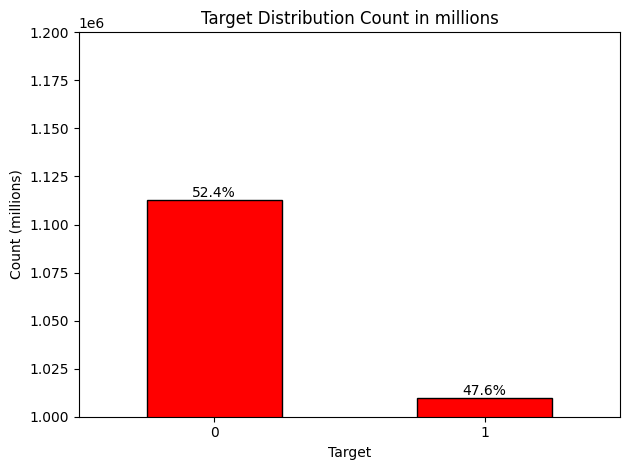

,count
target,
0,1112614
1,1009823


In [112]:
import matplotlib.pyplot as plt
import seaborn as sns


# Calculate counts and percentages
counts = df['target'].value_counts()
percentages = df['target'].value_counts(normalize=True) * 100

# Create the bar plot
ax = counts.plot(kind='bar', color='red', edgecolor='black')
plt.xlabel('Target')
plt.ylabel('Count (millions)')
plt.title('Target Distribution Count in millions')
plt.xticks(rotation=0)
plt.ylim(1000000, 1200000)

# Add text annotations for percentages
for i, v in enumerate(counts):
    ax.text(i, v, f'{percentages[i]:.1f}%',
            ha='center', va='bottom')

plt.tight_layout()
plt.show()

counts

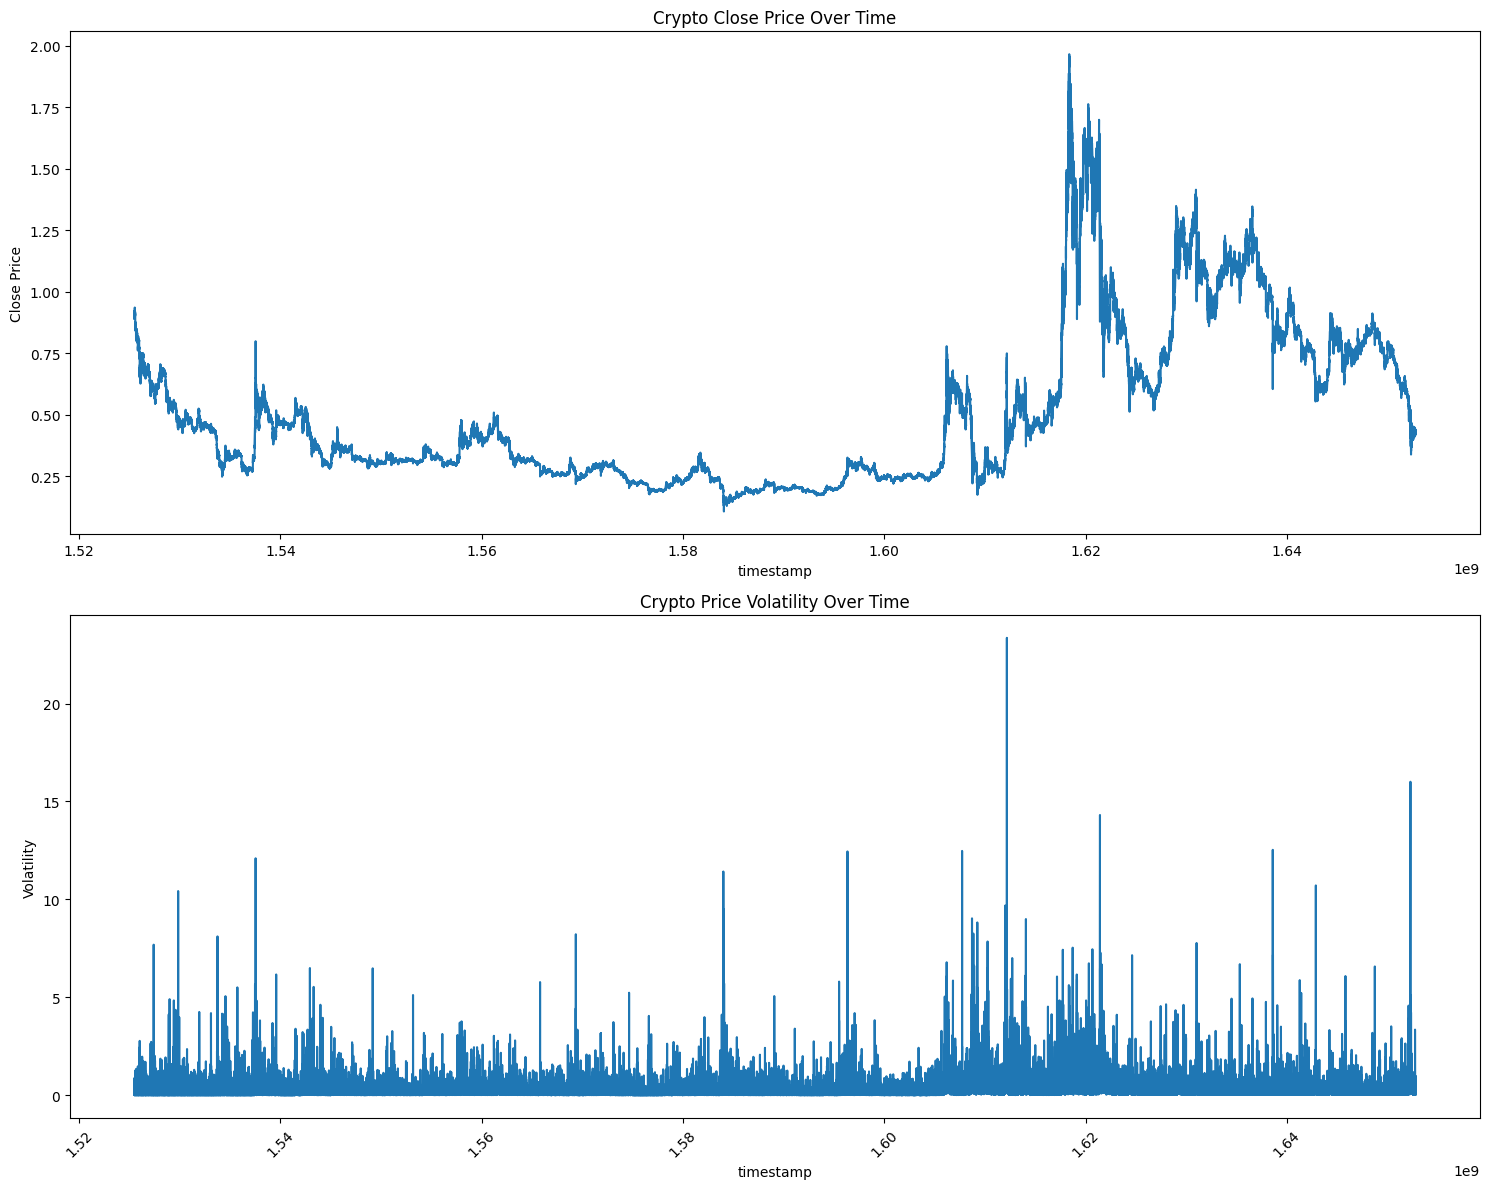

In [113]:
fig, axes = plt.subplots(2, 1, figsize=(15, 12))  # Create 2 rows, 1 column subplot

# Plot close price on the top axes
axes[0].plot(df['timestamp'], df['close'])
axes[0].set_title('Crypto Close Price Over Time')
axes[0].set_xlabel('timestamp')
axes[0].set_ylabel('Close Price')
axes[0].tick_params(bottom=True, labelbottom=True)  # Rotate x-axis labels only for the bottom plot
plt.xticks(rotation=45)  # Rotate x-axis labels for both plots (optional)

# Plot volatility on the bottom axes
axes[1].plot(df['timestamp'], df['volatility'])
axes[1].set_title('Crypto Price Volatility Over Time')
axes[1].set_xlabel('timestamp')
axes[1].set_ylabel('Volatility')

# Adjust layout (optional)
plt.tight_layout()

plt.show()

**Corr Heatmap:**

- **High Correlation between Volume and Quote Asset Volume:** These two features are nearly identical, suggesting potential redundancy.

- **Strong Correlations within Price Features:** Open, high, low, and close prices are highly correlated due to their relationship within a trading period.

- **Moderate Correlation between Number of Trades and Volumes:** A moderate positive relationship exists, indicating that more trades generally occur with higher volumes.

- **Weak Correlations between Target and Most Features:** The target variable (price increase/decrease) shows limited linear relationships with most features, suggesting the need for more complex models.

- **Strong Correlations among EMA and MACD Indicators:** These indicators are highly correlated due to their shared reliance on moving averages.

- **Moderate Correlation between Volatility and Price-Related Features:** Volatility is related to price changes and price range.

- **Expected Correlations for Lagged Features and Price Range:** These features exhibit expected correlations based on their definitions.

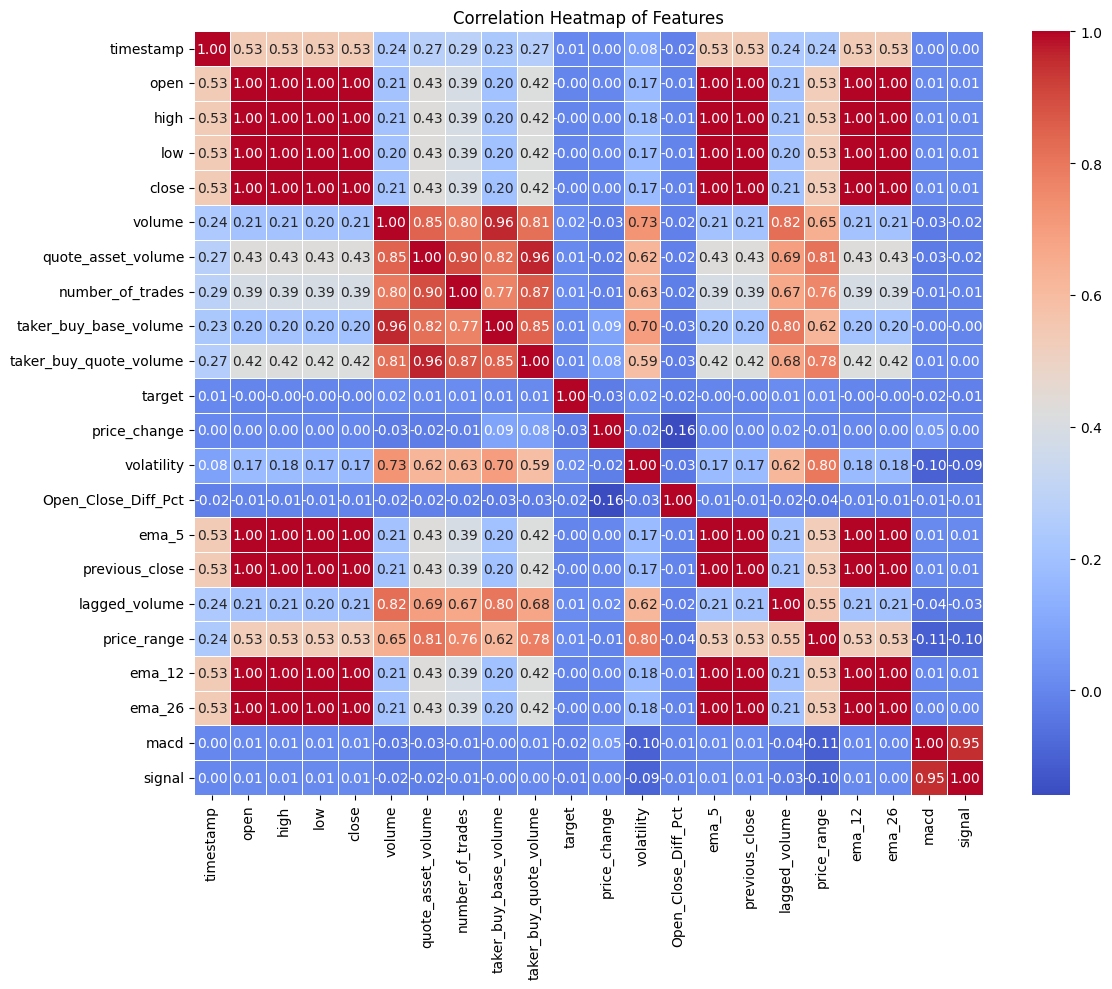

In [132]:
# Correlation Heatmap
corr_matrix = df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title('Correlation Heatmap of Features')
plt.tight_layout()
plt.show()

**Scatter Plot:**

- **No Clear Linear Relationship:** There's no strong linear correlation between trading volume and price change, suggesting that factors beyond volume influence price fluctuations.

- **Outliers:** A few outliers with exceptionally high volumes and significant price changes indicate potential market events or anomalies that warrant further investigation.

- **Clustering Around Zero Price Change:** Most data points are concentrated near zero price change, even with varying volumes, suggesting market stability or limited price movement within frequent trades.

- **Increased Volatility at Higher Volumes:** As volume increases, there's a slight tendency for price changes to become more volatile, but the relationship is not strong.

- **Multiple Factors Influence Price:** Volume alone is insufficient to predict price changes. Other factors like market sentiment, news events, and technical indicators likely play significant roles.

- **Outlier Analysis:** Outliers could represent unusual market conditions or potential manipulation. Further investigation is needed to understand their underlying causes.

- **Market Stability:** The clustering of data points around zero price change suggests a relatively stable market environment, especially for high liquidity assets.

- **Conditional Relationship:** While volume doesn't have a strong direct relationship with price change, it might be a contributing factor under certain conditions or in combination with other factors.

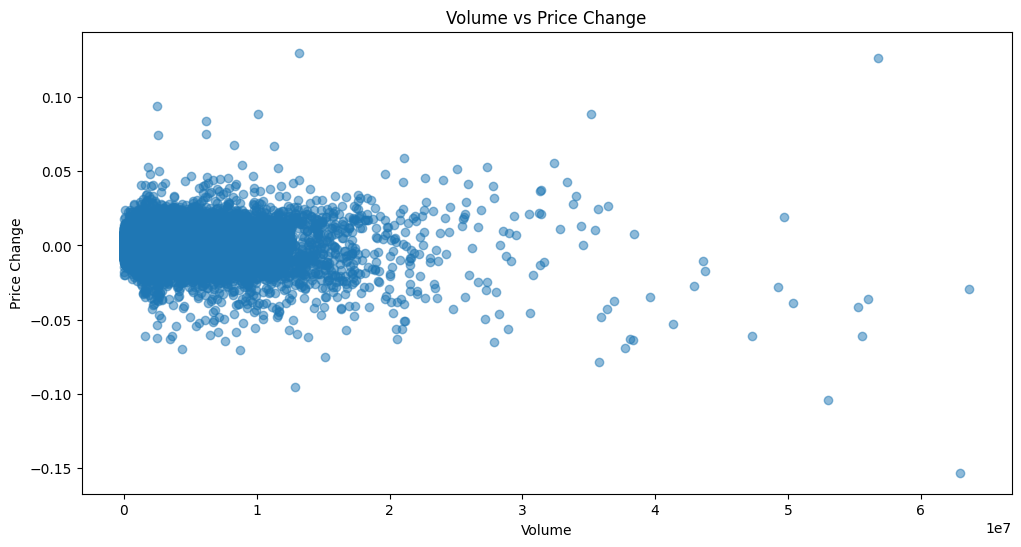

In [115]:
# Volume vs Price Change Scatter Plot
plt.figure(figsize=(12, 6))
plt.scatter(df['volume'], df['price_change'], alpha=0.5)
plt.title('Volume vs Price Change')
plt.xlabel('Volume')
plt.ylabel('Price Change')
plt.show()

**Model**

- Logistic Regression is a linear model for classification that estimates probabilities using a logistic function.

- StandardScaler: This scales our features to have zero mean and unit variance. It's particularly important for Logistic Regression, which is sensitive to the scale of input features.

- train_test_split: This function splits our data into training and testing sets. We're using a chronological split (shuffle=False) to respect the time series nature of our data.

In [116]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from joblib import dump, load

In [118]:
# split the variables
X = df.drop('target', axis=1)  # Features
y = df['target']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [119]:
# Create the logistic regression model
model = LogisticRegression(random_state=42)

# Train the model
model.fit(X_train_scaled, y_train)

LogisticRegression(random_state=42)

In [120]:
# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Print confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.53

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.92      0.67    222733
           1       0.53      0.10      0.17    201755

    accuracy                           0.53    424488
   macro avg       0.53      0.51      0.42    424488
weighted avg       0.53      0.53      0.43    424488


Confusion Matrix:
[[204971  17762]
 [181891  19864]]


**F1 Score: 0.53**

In [121]:
# Save the model and scaler using joblib
dump(model, 'logistic_regression_model.joblib')
dump(scaler, 'standard_scaler.joblib')
print("\nModel and scaler saved successfully.")


Model and scaler saved successfully.


**Test Data Usage**

- Using joblib

In [122]:
# Load the saved model and scaler
loaded_model = load('logistic_regression_model.joblib')
loaded_scaler = load('standard_scaler.joblib')
print("Model and scaler loaded successfully.")

Model and scaler loaded successfully.


In [123]:
test_df = dataframes['test']

fe_test = FeatureEngineering(test_df)
test_df = fe_test.engineer_features()

In [124]:
def drop_unnecessary_columns(df):
    """
    Drop any columns not seen during training (like 'row_id')
    """
    col_lst = df.columns.tolist()
    if 'target' in col_lst:
      df = df.drop('target', axis=1)
    if 'row_id' in col_lst:
      df = df.drop('row_id', axis=1)
    else: pass
    return df

In [125]:
test_df = drop_unnecessary_columns(test_df)
test_df

,timestamp,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_volume,taker_buy_quote_volume,...,volatility,Open_Close_Diff_Pct,ema_5,previous_close,lagged_volume,price_range,ema_12,ema_26,macd,signal
1,1652817540,0.4301,0.4303,0.4293,0.4302,275647.0,118478.9689,228,91260.0,39217.6312,...,0.232450,0.000000,0.430133,0.4301,101150.0,0.0010,0.430115,0.430107,0.000008,1.595442e-06
2,1652817600,0.4302,0.4302,0.4292,0.4299,134959.0,57979.2418,156,56685.0,24357.5448,...,0.232612,0.000000,0.430056,0.4302,275647.0,0.0010,0.430082,0.430092,-0.000010,-6.827217e-07
3,1652817660,0.4299,0.4303,0.4299,0.4301,316209.0,135979.4040,121,161740.0,69552.2691,...,0.093002,0.000000,0.430070,0.4299,134959.0,0.0004,0.430085,0.430093,-0.000008,-2.076921e-06
4,1652817720,0.4302,0.4307,0.4302,0.4303,107440.0,46243.7993,113,31096.0,13384.3384,...,0.116198,0.023250,0.430147,0.4301,316209.0,0.0005,0.430118,0.430108,0.000010,3.516338e-07
5,1652817780,0.4303,0.4306,0.4302,0.4306,45547.0,19606.1259,67,30426.0,13099.0668,...,0.092894,0.000000,0.430298,0.4303,107440.0,0.0004,0.430192,0.430144,0.000048,9.834432e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
909612,1707394200,0.5141,0.5144,0.5141,0.5143,115358.0,59321.7124,64,103183.0,53061.6505,...,0.058332,-0.019448,0.514286,0.5142,153779.0,0.0003,0.514061,0.513761,0.000300,2.047802e-04
909613,1707394260,0.5144,0.5144,0.5142,0.5143,100017.0,51433.4744,59,29333.0,15084.3792,...,0.038888,0.019444,0.514291,0.5143,115358.0,0.0002,0.514098,0.513801,0.000297,2.231374e-04
909614,1707394320,0.5143,0.5144,0.5142,0.5142,51665.0,26573.9877,46,33916.0,17445.9911,...,0.038895,0.000000,0.514261,0.5143,100017.0,0.0002,0.514113,0.513831,0.000283,2.350635e-04
909615,1707394380,0.5143,0.5144,0.5143,0.5143,28063.0,14433.0717,35,16810.0,8645.6538,...,0.019444,0.019448,0.514274,0.5142,51665.0,0.0001,0.514142,0.513865,0.000277,2.433934e-04


In [126]:
# Scale the test data using the previously fitted scaler
X_test_scaled = loaded_scaler.transform(test_df)

# Predict the target using the loaded model
y_pred_test = loaded_model.predict(X_test_scaled)


test_df['predicted_target'] = y_pred_test

print("\nTest Data with Predicted Targets:")
test_df[['predicted_target']].describe()


Test Data with Predicted Targets:


,predicted_target
count,909616.000000
mean,0.088726
std,0.284349
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000
